# Site Discovery Recommender - Walk-Forward Evaluation

This notebook demonstrates a site discovery/exploration recommender system:

**Problem**: Predict which sites a pilot will discover next based on their exploration history

**Approach**:
- **Training data**: Binary pilot-site interactions (visited or not)
- **Train/val/test split**: By pilots (each pilot in one split only)
- **Evaluation**: Walk-forward sequences simulating progressive discovery
  - For pilot visiting [S1, S2, S3, S4]: evaluate [S1]→S2, [S1,S2]→S3, [S1,S2,S3]→S4

**Model**: SVD-based collaborative filtering


In [1]:
import os
import logging

import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pickle
from scipy.stats import loguniform

from process import (
    load_flight_data, get_first_visits, filter_pilots_and_sites,
    split_pilots, create_walk_forward_sequences, create_interaction_matrix,
    build_train_site_vocabulary
)
from hyper_opt import (
    perform_hyperparameter_search, plot_hyperparameter_analysis,
    plot_metric_correlations, get_best_params, get_uniform
)
from metrics import evaluate_walk_forward, print_metrics_summary, aggregate_metrics
from svd import SVDRecommender
import utils
import plots

In [2]:
%load_ext autoreload
%autoreload 2

## 1. Setup and Load Data


In [3]:
# Database connection
load_dotenv()

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)

connection_string = "postgresql://{user}:{password}@{host}:{port}/{db}".format(
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    host=os.getenv('DB_HOST'),
    port=os.getenv('DB_PORT'),
    db=os.getenv('DB_NAME')
)
engine = create_engine(connection_string)

In [4]:
# Load flight data
df = load_flight_data(engine)

2025-10-18 11:06:22,856 - process - INFO - Loading flight data...
2025-10-18 11:06:47,834 - process - INFO - Loaded 1,211,925 flights
2025-10-18 11:06:48,510 - process - INFO - Unique pilots: 31,311
2025-10-18 11:06:48,526 - process - INFO - Unique sites: 252
2025-10-18 11:06:48,831 - process - INFO - Date range: 2015-01-01 to 2024-12-31


## 2. Extract First Visits and Filter


In [5]:
# Get first visit to each site for each pilot
first_visits = get_first_visits(df)


2025-10-18 11:06:59,854 - process - INFO - First visits: 179,907
2025-10-18 11:06:59,973 - process - INFO - Pilots with visits: 31,311
2025-10-18 11:06:59,980 - process - INFO - Unique sites visited: 252


In [6]:
# Filter to active pilots and sites
# Pilot must have visited at least 3 sites (to create meaningful sequences)
# Site must be visited by at least 5 pilots (to have enough training signal)
filtered_visits = filter_pilots_and_sites(
    first_visits, 
    min_sites_per_pilot=3,
    min_pilots_per_site=5
)

2025-10-18 11:07:09,608 - process - INFO - After filtering:
2025-10-18 11:07:09,712 - process - INFO -   Pilots: 18,921 (visited 3+ sites)
2025-10-18 11:07:09,715 - process - INFO -   Sites: 252 (visited by 5+ pilots)
2025-10-18 11:07:09,716 - process - INFO -   First visits: 162,795
2025-10-18 11:07:09,884 - process - INFO -   Sites per pilot - mean: 8.6, median: 6, max: 62


## 3. Split by Pilots


In [7]:
# Split pilots into train/val/test (70/15/15)
# Each pilot appears in exactly one split
train_df, val_df, test_df = split_pilots(
    filtered_visits,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_seed=42
)

2025-10-18 11:07:19,418 - process - INFO - 
Pilot-based split:
2025-10-18 11:07:19,419 - process - INFO -   Train: 13,244 pilots, 114,035 visits
2025-10-18 11:07:19,420 - process - INFO -   Val:   2,838 pilots, 24,700 visits
2025-10-18 11:07:19,421 - process - INFO -   Test:  2,839 pilots, 24,060 visits


## 4. Create Walk-Forward Sequences


In [8]:
# Create walk-forward evaluation sequences
# For pilot with [S1, S2, S3, S4]: create [S1]→S2, [S1,S2]→S3, [S1,S2,S3]→S4
val_sequences = create_walk_forward_sequences(val_df, min_history=1)
test_sequences = create_walk_forward_sequences(test_df, min_history=1)

2025-10-18 11:07:29,876 - process - INFO - 
Created 21,862 walk-forward sequences
2025-10-18 11:07:29,884 - process - INFO -   From 2,838 pilots
2025-10-18 11:07:29,898 - process - INFO -   Avg sequences per pilot: 7.7
2025-10-18 11:07:31,583 - process - INFO - 
Created 21,221 walk-forward sequences
2025-10-18 11:07:31,593 - process - INFO -   From 2,839 pilots
2025-10-18 11:07:31,603 - process - INFO -   Avg sequences per pilot: 7.5


In [9]:
# Example sequences
print("\nExample validation sequences:")
for i, seq in enumerate(val_sequences[:3]):
    print(f"     History IDs: {seq['history_sites']}")
    print(f"     History Names: {seq['history_names']}")
    print(f"     Target ID: {seq['target_site']}, Name: {seq['target_name']}")


Example validation sequences:
     History IDs: [245]
     History Names: ['Vértesszőlős']
     Target ID: 243, Name: Csolnok
     History IDs: [245, 243]
     History Names: ['Vértesszőlős', 'Csolnok']
     Target ID: 242, Name: Óbuda
     History IDs: [245, 243, 242]
     History Names: ['Vértesszőlős', 'Csolnok', 'Óbuda']
     Target ID: 185, Name: Col de La Forclaz


## 5. Train SVD Model - Including Hyperameter optimization


In [10]:
# Define hyperparameter search space
SEARCH_SPACE = {
    'n_factors': [32, 64, 96, 128],  # Discrete values
    'sigma_power': get_uniform(0.8, 3.),  # Continuous uniform distribution
}

# Fixed parameters (not searched)
FIXED_PARAMS = {
    'apply_idf': True
}

# Number of random combinations to try
N_ITER = 100

# Metric to optimize
METRIC = 'hit_rate'
K = 5 # K to optimize

Ks = [3, 5, 10] # Ks to report

In [11]:
# Create binary interaction matrix from training data
interaction_matrix, pilot_to_idx, site_to_idx, idx_to_site, site_id_to_name = create_interaction_matrix(train_df)

# Build training site vocabulary (for filtering eval sequences)
train_site_vocab = build_train_site_vocabulary(train_df)

2025-10-18 11:07:45,155 - process - INFO - 
Interaction matrix:
2025-10-18 11:07:45,156 - process - INFO -   Shape: 13244 pilots × 252 sites
2025-10-18 11:07:45,195 - process - INFO -   Density: 0.034168
2025-10-18 11:07:45,196 - process - INFO -   Total interactions: 114,035


In [12]:
# Prepare training data tuple
train_data = (interaction_matrix, pilot_to_idx, site_to_idx, idx_to_site, site_id_to_name, train_df)

# Run hyperparameter search
results_df = perform_hyperparameter_search(
    model_class=SVDRecommender,
    train_data=train_data,
    val_sequences=val_sequences,
    train_site_vocab=train_site_vocab,
    search_space=SEARCH_SPACE,
    fixed_params=FIXED_PARAMS,
    n_iter=N_ITER,
    metric=METRIC,
    k=K
)

# Display top results
print(f"\nTop 10 configurations by {METRIC}@{K}:")
results_df.head(10)

2025-10-18 11:07:48,914 - hyper_opt - INFO - Starting hyperparameter search with 100 iterations
2025-10-18 11:07:48,915 - hyper_opt - INFO - Optimizing for: hit_rate@5
Hyperparameter search:   0%|                                                                    | 0/100 [00:00<?, ?it/s]2025-10-18 11:07:48,926 - svd - INFO - IDF: min=2.041 mean=4.771 max=6.828
2025-10-18 11:07:50,478 - svd - INFO - SVD shapes: U=(13244, 96) s=(96,) Vt=(96, 252)
Hyperparameter search:   1%|▌                                                           | 1/100 [00:03<06:26,  3.90s/it]2025-10-18 11:07:52,827 - svd - INFO - IDF: min=2.041 mean=4.771 max=6.828
2025-10-18 11:07:54,253 - svd - INFO - SVD shapes: U=(13244, 96) s=(96,) Vt=(96, 252)
Hyperparameter search:   2%|█▏                                                          | 2/100 [00:07<05:55,  3.63s/it]2025-10-18 11:07:56,259 - svd - INFO - IDF: min=2.041 mean=4.771 max=6.828
2025-10-18 11:07:59,086 - svd - INFO - SVD shapes: U=(13244, 32) s=(32,) Vt


Top 10 configurations by hit_rate@5:


,n_factors,sigma_power,hit_rate,mrr,ndcg,coverage,avg_log_pop,hit_rate@5
84,128,1.575651,0.382307,0.217463,0.258255,0.988095,6.494064,0.382307
15,128,1.605996,0.382170,0.217351,0.258144,0.988095,6.502032,0.382170
58,128,1.404388,0.382033,0.216474,0.257417,0.980159,6.442227,0.382033
54,128,1.788791,0.381072,0.217049,0.257630,0.992063,6.537592,0.381072
78,128,1.716322,0.380523,0.217130,0.257569,0.992063,6.525350,0.380523
27,128,1.889389,0.379243,0.216306,0.256617,0.992063,6.549178,0.379243
86,128,1.974997,0.377733,0.216064,0.256061,0.992063,6.554082,0.377733
43,128,1.993931,0.377276,0.215682,0.255656,0.992063,6.553979,0.377276
68,128,2.039206,0.376452,0.215009,0.254923,0.992063,6.554385,0.376452
4,96,1.810348,0.371787,0.210323,0.250222,0.996032,6.433758,0.371787


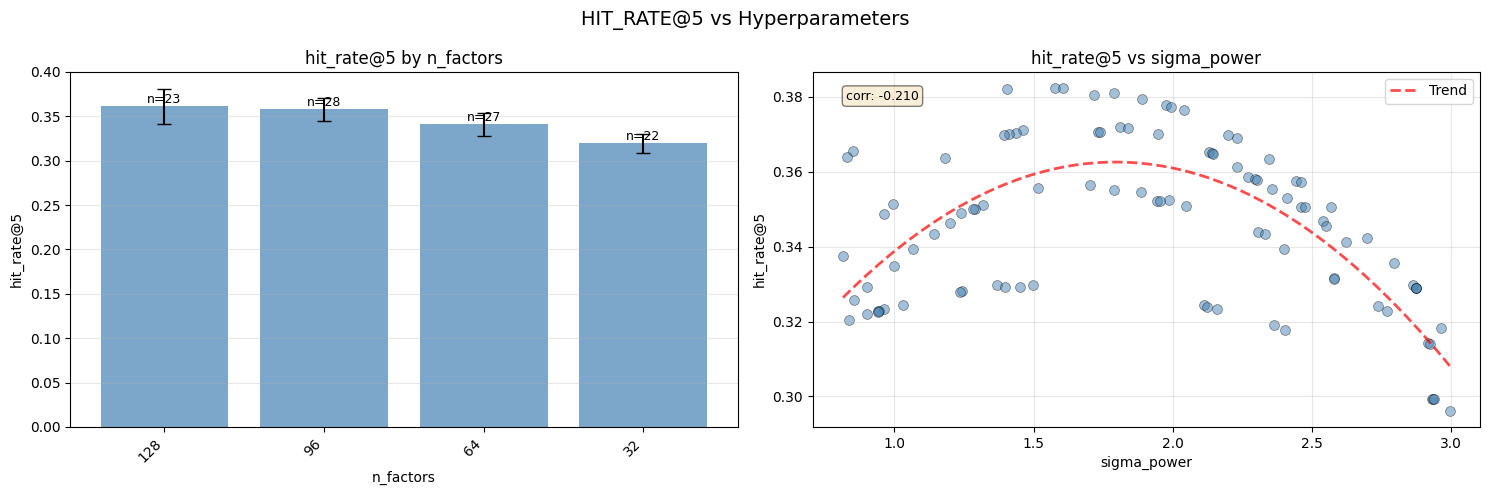

In [13]:
# Plot hyperparameter analysis
param_names = list(SEARCH_SPACE.keys())
fig = plot_hyperparameter_analysis(
    results_df,
    param_names,
    metric=METRIC,
    k=K,
    figsize=(15, 5)
)
plt.show()

In [14]:
# Re-train with best params
best_config = results_df.iloc[0]
best_params = {key: best_config[key] for key in SEARCH_SPACE.keys()}

model = SVDRecommender(**best_params)
model.fit(interaction_matrix, pilot_to_idx, site_to_idx, idx_to_site, site_id_to_name)

2025-10-18 11:12:08,342 - svd - INFO - IDF: min=2.041 mean=4.771 max=6.828
2025-10-18 11:12:08,600 - svd - INFO - SVD shapes: U=(13244, 128) s=(128,) Vt=(128, 252)


## 6. Evaluate on Validation Set


In [15]:
utils.print_sample_sequence(val_sequences[100], model, top_k=10)

Pilot's history: ['Bassano', 'Mieroszów']
Actual next site: Černá hora (ID: 4)

Top 10 recommendations:
  1. Andrzejowka: 0.8072
  2. Černá hora: 0.7475 ← TARGET
  3. Srbce: 0.7020
  4. Dolní Morava: 0.6589
  5. Kobala: 0.6568
  6. Lijak: 0.6394
  7. Col Rodella: 0.6315
  8. Zvičina: 0.6307
  9. Kozákov: 0.6027
  10. Meduno: 0.5929


In [16]:
# Evaluate using walk-forward sequences
# Pass train_df to compute coverage and avg_log_pop metrics
val_metrics = evaluate_walk_forward(
    model,
    val_sequences,
    train_site_vocab,
    train_df=train_df,
    k_values=Ks,
    verbose=True
)

2025-10-18 11:12:13,086 - metrics - INFO - Computed popularity for 252 sites
2025-10-18 11:12:13,110 - metrics - INFO - Evaluating 21,862 valid sequences (out of 21,862)
100%|███████████████████████████████████████████████████████████████████████████| 21862/21862 [00:02<00:00, 9601.48it/s]
2025-10-18 11:12:15,390 - metrics - INFO - 
2025-10-18 11:12:15,392 - metrics - INFO - Walk-Forward Evaluation Results
2025-10-18 11:12:15,394 - metrics - INFO - ============================================================
2025-10-18 11:12:15,395 - metrics - INFO - 
Metrics @ K=3:
2025-10-18 11:12:15,396 - metrics - INFO -   Hit Rate@3:  0.2852
2025-10-18 11:12:15,398 - metrics - INFO -   MRR:           0.2381
2025-10-18 11:12:15,401 - metrics - INFO -   NDCG@3:      0.2184
2025-10-18 11:12:15,402 - metrics - INFO -   Coverage@3:  0.9841 (248/252 sites)
2025-10-18 11:12:15,406 - metrics - INFO -   Avg Log-Pop@3: 6.5484
2025-10-18 11:12:15,408 - metrics - INFO - 
Metrics @ K=5:
2025-10-18 11:12:15,411

## 7. Evaluate on Test Set


In [17]:
# Evaluate on test set
# Pass train_df to compute coverage and avg_log_pop metrics
test_metrics = evaluate_walk_forward(
    model,
    test_sequences,
    train_site_vocab,
    train_df=train_df,
    k_values=Ks,
    verbose=True
)

2025-10-18 11:12:18,110 - metrics - INFO - Computed popularity for 252 sites
2025-10-18 11:12:18,132 - metrics - INFO - Evaluating 21,221 valid sequences (out of 21,221)
100%|███████████████████████████████████████████████████████████████████████████| 21221/21221 [00:02<00:00, 9394.16it/s]
2025-10-18 11:12:20,394 - metrics - INFO - 
2025-10-18 11:12:20,395 - metrics - INFO - Walk-Forward Evaluation Results
2025-10-18 11:12:20,395 - metrics - INFO - ============================================================
2025-10-18 11:12:20,396 - metrics - INFO - 
Metrics @ K=3:
2025-10-18 11:12:20,398 - metrics - INFO -   Hit Rate@3:  0.2863
2025-10-18 11:12:20,400 - metrics - INFO -   MRR:           0.2429
2025-10-18 11:12:20,402 - metrics - INFO -   NDCG@3:      0.2209
2025-10-18 11:12:20,403 - metrics - INFO -   Coverage@3:  0.9802 (247/252 sites)
2025-10-18 11:12:20,405 - metrics - INFO -   Avg Log-Pop@3: 6.5293
2025-10-18 11:12:20,407 - metrics - INFO - 
Metrics @ K=5:
2025-10-18 11:12:20,411

## 8. Visualize Results


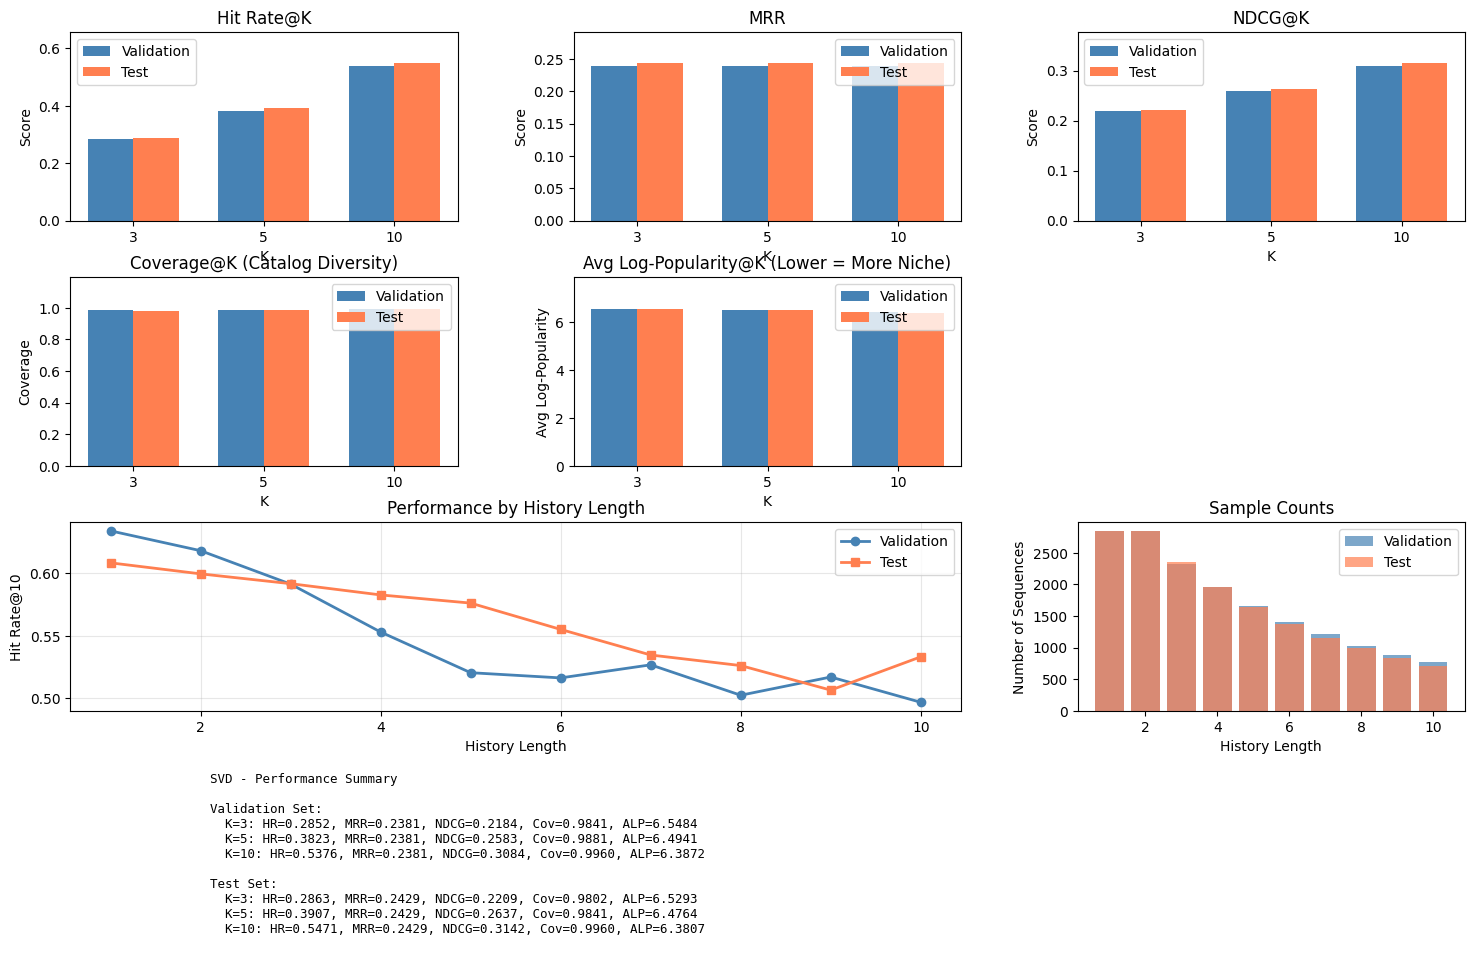

In [18]:
# Create a comprehensive dashboard with all visualizations
fig = plots.create_results_dashboard(
    val_metrics,
    test_metrics,
    model_name='SVD',
    k_values=Ks,
)
plt.show()

## 9. Save Model and Results


In [19]:
# Save the trained model
model.save('svd_model_walk_forward.pkl')

# Aggregate and save metrics
results = {
    'model_type': 'SVD',
    'n_factors': model.n_factors,
    'val_metrics': aggregate_metrics(val_metrics),
    'test_metrics': aggregate_metrics(test_metrics),
    'n_sites': len(site_to_idx),
    'n_train_pilots': len(train_df['pilot'].unique()),
    'n_val_pilots': len(val_df['pilot'].unique()),
    'n_test_pilots': len(test_df['pilot'].unique()),
    'n_train_visits': len(train_df),
    'n_val_sequences': len(val_sequences),
    'n_test_sequences': len(test_sequences),
}

with open('svd_results_walk_forward.pkl', 'wb') as f:
    pickle.dump(results, f)

print("\nModel and results saved!")
print("\nSummary:")
print(f"  Model: SVD with {model.n_factors} factors")
print(f"  Sites: {len(site_to_idx)}")
print(f"  Train pilots: {results['n_train_pilots']}")
print(f"  Val pilots: {results['n_val_pilots']}")
print(f"  Test pilots: {results['n_test_pilots']}")
print(f"\nValidation Performance:")
print(f"  Hit Rate@10: {results['val_metrics']['overall'][10]['hit_rate']:.4f}")
print(f"  MRR: {results['val_metrics']['overall'][10]['mrr']:.4f}")
print(f"  NDCG@10: {results['val_metrics']['overall'][10]['ndcg']:.4f}")
print(f"\nTest Performance:")
print(f"  Hit Rate@10: {results['test_metrics']['overall'][10]['hit_rate']:.4f}")
print(f"  MRR: {results['test_metrics']['overall'][10]['mrr']:.4f}")
print(f"  NDCG@10: {results['test_metrics']['overall'][10]['ndcg']:.4f}")

2025-10-18 11:12:27,141 - svd - INFO - Saved SVDRecommender to svd_model_walk_forward.pkl



Model and results saved!

Summary:
  Model: SVD with 128 factors
  Sites: 252
  Train pilots: 13244
  Val pilots: 2838
  Test pilots: 2839

Validation Performance:
  Hit Rate@10: 0.5376
  MRR: 0.2381
  NDCG@10: 0.3084

Test Performance:
  Hit Rate@10: 0.5471
  MRR: 0.2429
  NDCG@10: 0.3142
